In [ ]:
!pip install keras-unet-collection
#!pip install focal-loss

In [ ]:
import tensorflow as tf
import os
import sys
import numpy as np
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
import time
import tensorflow_hub as hub
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras_unet_collection import models, losses
#from focal_loss import BinaryFocalLoss

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


resizing training images and masks


100%|██████████| 478/478 [03:53<00:00,  2.05it/s]


Done!


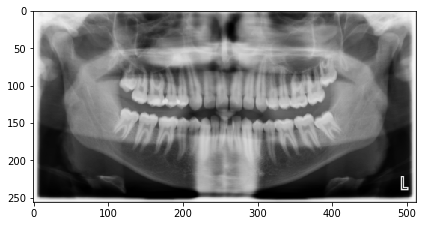

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


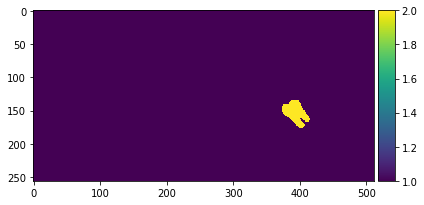

In [ ]:
#pre-processing and check all images and masks correctly read
IMG_WIDTH = 512
IMG_HEIGHT = 256
IMG_CHANNELS = 1
 
DATA_PATH = '/Path--/images/' # Training original images
Mask_path1= '/Path--/masks/'  # Segmentation Map


seed = 42
random.seed = seed
np.random.seed = seed
 
image_ids = next(os.walk(DATA_PATH))[2]

len(image_ids)
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('resizing training images and masks')
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
  try:
    path = DATA_PATH 
    img = imread(path+ id_)[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(Mask_path1))[2]:
      if mask_file==id_:
        #print(Mask_path1 +  mask_file)
        mask_ = imread(Mask_path1 + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y[n] = mask
  except:
    print('error')

x_train=X 
y_train=Y

print('Done!')

image_x = random.randint(0, len(image_ids))
imshow(x_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x])+1)
plt.show()

In [ ]:
#test images
TEST_PATH = '/Path--/images/'

test_ids = next(os.walk(TEST_PATH))[2]

len(test_ids)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sizes_test=[]
print('resizing training images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH 
  img = imread(path+ id_)[:,:]
  sizes_test.append([img.shape[0],img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n]=img 

resizing training images


100%|██████████| 119/119 [00:29<00:00,  4.07it/s]


#Model

In [ ]:
#Build U-Net model

# Input layer
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#opt = keras.optimizers.Adam(learning_rate=0.00001)
#model.compile(optimizer='adam', loss=[BinaryFocalLoss(gamma=2,label_smoothing=0.1,pos_weight=.25)], metrics=['accuracy', losses.dice_coef])
#model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0), metrics=['accuracy', losses.dice_coef])
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy', losses.dice_coef])
model.summary()

In [ ]:
from keras import backend as K

In [ ]:
#Modelcheckpoint-> save model after every epoch
#save_best_only -> the latest best model will not be overwritten 
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/model_3m.h5', verbose=1, save_best_only=True)
callbacks= [
            tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss'),
            tf.keras.callbacks.TensorBoard(log_dir='./logs2')]
results = model.fit(x_train,y_train, batch_size=10, epochs=50, callbacks=callbacks)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs2

In [ ]:
#Save weights only
model.save_weights('/content/unet_weights.h5')

In [ ]:
#Save model
t = time.time()
my_keras_model_filepath = '/content/unet_model.h5'.format(int(t))
print(my_keras_model_filepath)
model.save(my_keras_model_filepath)

In [ ]:
training_loss=results.history['loss']
training_accuracy=results.history['accuracy']
#validation_loss=results.history['val_loss']
#validation_accuracy=results.history['val_accuracy']

epochs_range=range(len(training_accuracy))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
#plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
#plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
idx = random.randint(0, len(x_train))
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

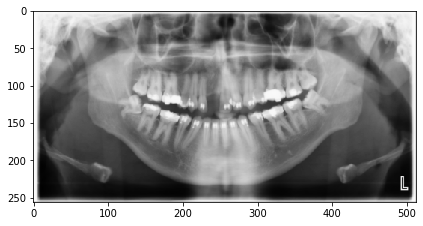

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


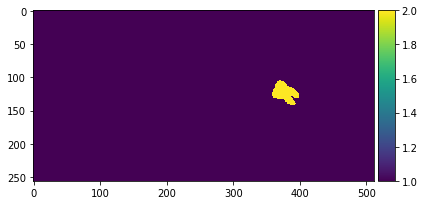

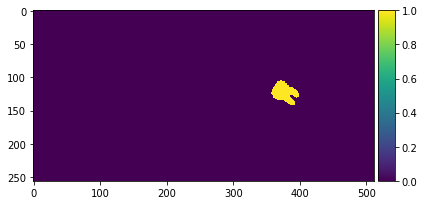

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix])+1)
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

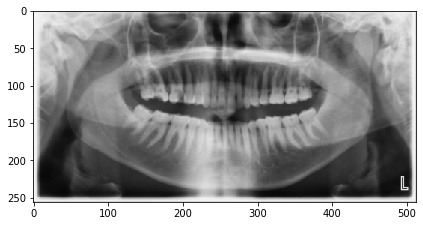

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


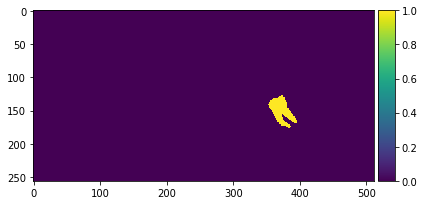

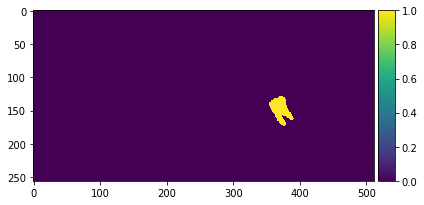

In [ ]:
'''
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(x_train[int(x_train.shape[0]*0.9):][ix]-1)
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
'''

In [ ]:
test_paths = os.listdir(TEST_PATH)
print(len(test_paths), 'test images found')

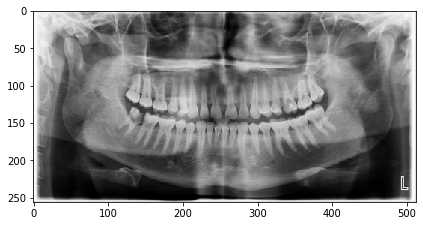

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


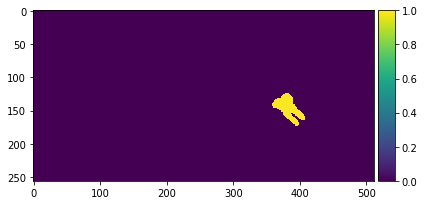

In [ ]:
#testing with test set
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

# Support References:


*   https://stackoverflow.com/questions/10989005/do-i-understand-os-walk-right
*   https://www.youtube.com/watch?v=68HR_eyzk00&t=938s 
*   https://www.youtube.com/watch?v=RaswBvMnFxk
*   https://github.com/bnsreenu/python_for_microscopists/blob/master/074-Defining%20U-net%20in%20Python%20using%20Keras.py
* https://www.youtube.com/watch?v=kaE7jQqIFI8
* https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py
* https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=8p3Tbx8cWEFA
* https://focal-loss.readthedocs.io/en/latest/


